# Installation

To set up the python environment, we will use Anaconda (<a href="https://www.anaconda.com"> www.anaconda.com</a>). Click the link, find `Free download`, and follow the instructions.


Once installed, search for the app, which should be called something like **Anaconda-Navigator**. Once *Navigator* starts,  go to *Environments*, and *Search Packages*. Please check for the following packages:
- numpy
- scipy
- matplotlib
- notebook (jupyter notebook)
- numba
- uncertainties
- pybind11

`pybind11-abi`  probably exists, but `pybind11` probably not. `uncertainties` is also probably missing. 

When in *Environments* of *Navigator*, please change the packages which you see from `installed` to `All` and than search again for `pybind11` and `uncertainties`. If you find them, install them.

If they still don't show up, then you can issue the following in the command line:

`conda install -c conda-forge uncertainties`


We will also need a text editor for python codes (in addition to jupyter notebooks). **Spyder** is part of Anaconda, and is very powerful editor. You can find it inside *Anaconda-Navigator*.

But other editors of your choice are equally good (for example *emacs* or *Aquamacs* or *vim* or *vi*)

Some examples to speed up the code will be given in C++. It is not essential to have it, but you will learn more if you can set up the environment with a C++ compiler (such as gcc), which can be combined with Python. For installation instructions, see the `Optional installation of C++` below. We will also show examples below.

We will test the installation with an excercise of plotting **Mandelbrot set.**

## Mandelbrot set

Wikipedia: The Mandelbrot set $M$ is defined by a family of complex quadratic polynomials $f(z) = z^2 + z_0$ where $z_0$ is a complex parameter. For each $z_0$, one considers the behavior of the sequence $(f(0), f(f(0)), f(f(f(0))), · · ·)$ obtained by iterating $f(z)$ starting at $z=0$, which either escapes to infinity or stays
within a disk of som finite radius. The *Mandelbrot set* is defined as the set of points $z_0$, such that the above sequence does not escape to infinity.

More concretely, the sequence is : $(z_0,z_0^2+z_0,z_0^4+2 z_0^3+z_0^2+z_0,...)$.

For large $z_0$ it behaves as $z_0^{2n}$ and clearly diverges at large $n$. Consequently, large $z_0$ is not part of the set. 

For small $z_0$, it is of the order of $z_0+O(z_0^2)$, and is small when $z_0$ is small. Such $z_0$ are part of the set.

To determine that certain $z_0$ is not part of the *Mandelbrot set*, we check if $|f(f(f(....)))|>2$. 
This treshold is sufficient, because the point with the largest magnitude that is still in the set is -2. Indeed, if we set $z_0=-2$, we see that $f(f(0))=(-2)^2-2=2$ and $f(f(f(0)))=2^2-2=2$, and for any number of itterations the sequence remains equal to $2$. Such sequence remains finite, and by definition $z_0=-2$ is part of the set, and $f(f(f(...)))=2$ might lead to finite sequence. 

For any other point $z_0\ne -2$, we can show that once $f(f(f(...)))$ becomes $2$, it will lead to diverging sequence. For example, for $z_0=1$ we have $f(f(0))=2$ and $f(f(f(0)))=5$, and clearly grows.

We will make density plot, with $Re(z_0)$ on $x$-axis, and $Im(z_0)$ on $y$-axis, and color will denote how long it took for the sequence to have absolute value equal to 2. The mandelbrot set will have one color, and all other colors 



In [1]:
from numpy import * # because arrays are defined in numpy

def Mand(z0, max_steps):
    z = 0j  # no need to specify type. 
    # To initialize to complex number, just assign 0j==i*0
    for itr in range(max_steps):
        if abs(z)>2:
            return itr
        z = z*z + z0
    return max_steps


def Mandelbrot(ext, Nxy, max_steps):
    """
    ext[4]    -- array of 4 values [min_x,max_x,min_y,max_y]
    Nxy       -- int number of points in x and y direction
    max_steps -- how many steps we will try at most before we conclude the point is in the set
    """
    data = zeros((Nxy,Nxy)) # initialize a 2D dynamic array
    for i in range(Nxy):
        for j in range(Nxy):
            x = ext[0] + (ext[1]-ext[0])*i/(Nxy-1.)
            y = ext[2] + (ext[3]-ext[2])*j/(Nxy-1.)
            # creating complex number of the fly
            data[i,j] = Mand(x + y*1j, max_steps)  
    return data
# data now contains integers. 
# MandelbrotSet has value 1000, and points not in the set have value <1000.

In [2]:
data = Mandelbrot([-2,1,-1,1], 500, 1000)

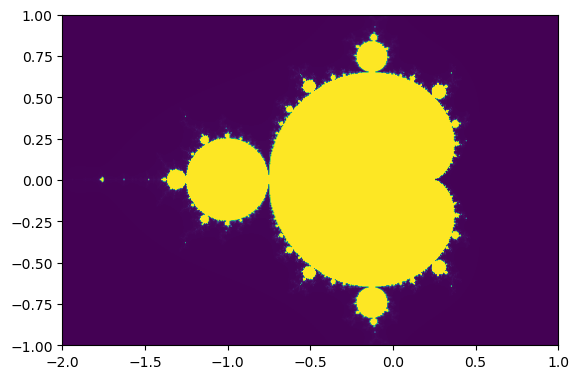

In [3]:
from pylab import *    # plotting library
%matplotlib inline

ext=[-2,1,-1,1]
# pylab's function for displaying 2D image
imshow(transpose(data), extent=ext)  

This resolution is somewhat low, and we would like to increase $N_{xy}$ to 1000. But this would make the code 4-times slower. The code is already time consuming.
Let's time it. 

For that we need to include *time* and use *time.time()* routine.

In [4]:
import time            # timeing
t0 = time.time()
data = Mandelbrot([-2,1,-1,1], 1000, 1000)
t1 = time.time()
print ('clock time: ',t1-t0,'s')

clock time:  11.382987022399902 s


We can speed up the code with package **numba**: <a href="https://numba.pydata.org">https://numba.pydata.org</a>.

In the simplest case, we just add two lines of code: 

`from numba import njit`

`@njit`


Limitations of Numba:
- Numba only accelerates code that uses scalars or (N-dimensional) arrays. You can’t use built-in types like `list` or `dict` or your own custom classes.
- You can’t allocate new arrays in accelerated code.
- You can’t use recursion.
Most of those limitations are removed if using Cython.

Numba has been getting a lot better, even just over the past few months (e.g., they recently added support for generating random numbers).


In [5]:
from numpy import * # because arrays are defined in numpy
from numba import njit  # This is the new line with numba

@njit   # this is an alias for @jit(nopython=True)
def Mand(z0, max_steps):
    z = 0j  # no need to specify type. 
    # To initialize to complex number, just assign 0j==i*0
    for itr in range(max_steps):
        if abs(z)>2:
            return itr
        z = z*z + z0
    return max_steps

@njit
def Mandelbrot2(ext, Nxy, max_steps):
    """
    ext[4]    -- array of 4 values [min_x,max_x,min_y,max_y]
    Nxy       -- int number of points in x and y direction
    max_steps -- how many steps we will try at most before we conclude the point is in the set
    """
    data = zeros((Nxy,Nxy)) # initialize a 2D dynamic array
    for i in range(Nxy):
        for j in range(Nxy):
            x = ext[0] + (ext[1]-ext[0])*i/(Nxy-1.)
            y = ext[2] + (ext[3]-ext[2])*j/(Nxy-1.)
            # creating complex number of the fly
            data[i,j] = Mand(x + y*1j, max_steps)  
    return data
# data now contains integers. 
# MandelbrotSet has value 1000, and points not in the set have value <1000.

In [7]:
import time            # timeing
t0 = time.time()
data = Mandelbrot2(array([-2,1,-1,1]), 1000, 1000)
t1 = time.time()
print ('clock time: ',t1-t0,'s')

clock time:  0.754727840423584 s


This is substantial speedup of order of 20, considering a small modification required.

We can slightly improve the code by making the outer loop over i parallel, and by allocating array for data outside the optimized routine.

- We will allocate array data outside `Mandelbrot` function
- We will change `@njit` to `@njit(parallel=True)` and use `prange` instead of `range` for loop over j. Namely, if we don't change `range` to `prange` both loops will be attempted to be parallelized, which leads to nested parallelization, which either fails or is very innefficient.


The example code is:

In [8]:
from numpy import * # because arrays are defined in numpy
from numba import njit  # This is the new line with numba
from numba import prange

@njit   # this is an alias for @jit(nopython=True)
def Mand(z0, max_steps):
    z = 0j  # no need to specify type. 
    # To initialize to complex number, just assign 0j==i*0
    for itr in range(max_steps):
        if abs(z)>2:
            return itr
        z = z*z + z0
    return max_steps

@njit(parallel=True)
def Mandelbrot3(data, ext, max_steps):
    """
    ext[4]    -- array of 4 values [min_x,max_x,min_y,max_y]
    Nxy       -- int number of points in x and y direction
    max_steps -- how many steps we will try at most before we conclude the point is in the set
    """
    Nx,Ny = shape(data) # 2D array should be already allocated we get its size
    for i in range(Nx):
        for j in prange(Ny):    # note that we used prange instead of range.
                                # this switches off parallelization of this loop, so that
                                # only the outside loop over i is parallelized.
            x = ext[0] + (ext[1]-ext[0])*i/(Nx-1.)
            y = ext[2] + (ext[3]-ext[2])*j/(Ny-1.)
            # creating complex number of the fly
            data[i,j] = Mand(x + y*1j, max_steps)  
# data now contains integers. 
# MandelbrotSet has value 1000, and points not in the set have value <1000.

In [10]:
import time            # timeing
data = zeros((1000,1000))
t0 = time.time()
Mandelbrot3(data, array([-2,1,-1,1]), 1000)
t1 = time.time()
print ('clock time: ',t1-t0,'s')

clock time:  0.22559285163879395 s


With this modification, we get speedup of the order of 50.
Note that pure C++ code with OpenMP could gives us speedup of the order of 200, i.e., extra factor of 4 on MAC with 8 cores.


Finally, let us improve the plot a bit. We will transform the data to plot `-logarithm` of the data (density logplot), so that *Mandelbrot Set* has the smallest value (appears black), and borders are more apparent.

We will use different color scheme, for example `hot` color scheme from `matplotlib.cm`.

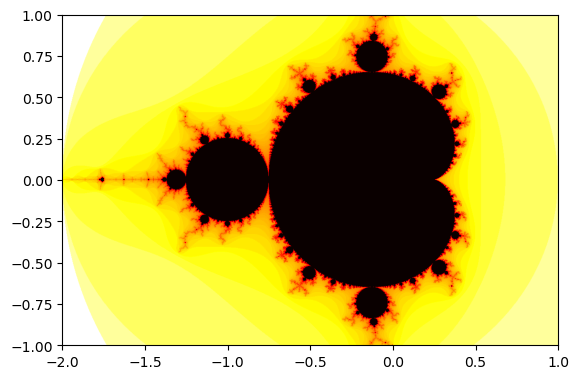

In [11]:
import matplotlib.cm as cm

imshow(-log(data.T), extent=[-2,1,-1,1], cmap=cm.hot)  

## Optional: Using C++ with `pybind11` to speed up the code 

To make the code as fast as in compiler languages (C++ or fortran), we can rewrite the slow part directly in C++, and use pybind11 to produce a python module from C++ code.

### Optional installation of C++. These instructions are MAC specific

- Install `Xcode` package from `App Store`
- Install "Command Line Tools" parts of `Xcode`. You can check if "Command Line Tools" are already installed by issuing the following in the`terminal`:

  `xcode-select --print-path`.

  If you get no output, then issue the following command in your `terminal`:

  `xcode-select —-install`

  Xcode contains `C/C++` compiler (`gcc/g++`). Check if installation was successful by issuing in `terminal`:

  `gcc --version`
  
  It is just a link to apples native Clang. It contains `make` utility.
  Xcode also contains many libraries, for example, BLAS and LAPACK libraries, which can be linked by adding linker option: `-framework Accelerate`.


### Return to `pybind11` to speed up the code 

The function `mand` is written in conventional C++ language. For storage, we use type `py::array_t<double>`, which can convert any numpy arrays to a simple C++ container, that can be accessed conventionally.

We do that in the very top of the function, where we extract proper type from `py::array_t<double>`

`auto dat = data.mutable_unchecked<2>();`


The `dat` object behaves as normal 2D array, which can be accessed via `dat(j,i)=...`. 

To have access to these Python types, we need to include a few `pybind11` header files:

`#include "pybind11/pybind11.h"`<br>
`#include "pybind11/numpy.h"`<br>
`#include "pybind11/stl.h"`

The crucial difference between normal C++ code or Python module is that the `main()` function is replaced by `PYBIND11_MODULE(imanc,m)`, which creates shared library that Python recognizes as module, rather than executable. Here, the first argument has to match the name of the file compiled file (`imanc.cc` and `imanc`). The second argument creates object with name `m`, which can than be filled with functions or classes that are exposed to Python. We just add our function `mand` to it : `m.def("mand", &mand);`. The string `"mand"` gives name to this function in Python, which could in general be different, and `&mand` takes the pointer to existing C++ routine and binds it to Python module. The line `m.doc() = "..."` adds some documentation to the module as seen from Python.


The entire C++ code below is just a long string (because jupyter has very limited support for C++). The last three lines in the cell open new file `imanc.cc`, write the code to this file, and close it, so that all content is safely written to this file.


In [12]:
CPP_code="""
#include "pybind11/pybind11.h"
#include "pybind11/numpy.h"
#include "pybind11/stl.h"
#include <cstdint>

namespace py = pybind11;
using namespace std;

void mand(py::array_t<double>& data, int Nx, int Ny, int max_steps, const vector<int>& ext)
{
  auto dat = data.mutable_unchecked<2>();
  #pragma omp parallel for
  for (int i=0; i<Nx; i++){
    for (int j=0; j<Ny; j++){
      dat(j,i) = max_steps;
      double x = ext[0] + (ext[1]-ext[0])*i/(Nx-1.);
      double y = ext[2] + (ext[3]-ext[2])*j/(Ny-1.);
      complex<double> z0(x,y);
      complex<double> z=0;
      for (int itr=0; itr<max_steps; itr++){
        if (norm(z)>4.){
          dat(j,i) = itr;
          break;
        }
        z = z*z + z0;
      }
    }
  }
}

PYBIND11_MODULE(imanc,m){
  m.doc() = "pybind11 wrap for mandelbrot";
  m.def("mand", &mand);
}
"""
file = open('imanc.cc', mode='w')
file.write(CPP_code)
file.close()

Next we check that the file now exists in the working directory, where our jupyter notebook is located.

In [13]:
cmd = 'ls -l'
!{cmd}

total 2880
-rw-r--r--@ 1 haule  staff  588532 Jan  2 22:19 Interactive MandelbrotSet.html
-rw-r--r--  1 haule  staff    4501 Jan  6 16:00 Interactive MandelbrotSet.ipynb
-rw-r--r--@ 1 haule  staff  443588 Jan 10 00:48 Introduction to Comp Phys 488.html
-rw-r--r--  1 haule  staff  246711 Jan 10 23:20 Introduction to Comp Phys 488.ipynb
drwxr-xr-x  3 haule  staff      96 Jan  6 15:56 Teaching
-rw-r--r--  1 haule  staff     828 Jan 10 23:21 imanc.cc
-rwxr-xr-x  1 haule  staff  174789 Jan 10 23:09 imanc.so
drwxr-xr-x  6 haule  staff     192 Jan  6 13:29 pybind11


Next we need to compile C++ code to create proper shared libray, which Python recognizes. This string is platform dependent, and in its current form is most appropriate for MAC. It needs some modification on other platforms. Please read the <a href="https://pybind11.readthedocs.io/en/stable/basics.html#compiling-the-test-cases"> documentation</a> and <a href="https://pybind11.readthedocs.io/en/stable/compiling.html">instructions</a> to modify the compile line.

We will again create a long string, which is a line that is normally written in comand line, and we will than execute it on the system.

As said, the complile line is system dependend, and will most likely need modification. Here is the explanation of the command:

- `g++-12` is tha name of the C++ compiler on the sytstem. Most likely needs to be changed to your existsing C++ compiler.

- `python3 -m pybind11 --includes` is line that can be executed in command line (try it) and should give the location of `pybind11` include files. Each computer will have these files at slightly different location, but this command should work in most systems.

- `-undefined dynamic_lookup` is something MAC specific. Withouth this flag, the compiler will issue errors of missing symbols in the module. In other operating systems should not be needed.

- `-O3` switches on agrresive optimization.

- `-fopenmp` allows the code to be parallelized by openMP. Namely the code above has a line `#pragma omp parallel for`, which parallelizes the first loop over i, provided that we also add this flag during compilation.

- `shared` tells the compiler that we are producing shared library

- `-std=c++11` forces compiler to use C++ 2011 standard. We could use later standard, but not earlier.

- `-fPIC` makes code position independent, which is required for shared library

- `imanc.cc` is the name of our file that is being compiled.

- `-o imanc.so` says that the output file will be called `imanc.so`. The Python module is thus named `imanc`.


In [15]:
#cmd="g++ `python -m pybind11 --includes` -undefined dynamic_lookup -O3 -shared -std=c++11 -fPIC imanc.cc -o imanc.so"
cmd="g++-13 -fopenmp `python -m pybind11 --includes` -undefined dynamic_lookup -O3  -shared -std=c++11 -fPIC imanc.cc -o imanc.so"

!{cmd}

Finally, we import this generated module `imanc` and use the exposed function `mand` as `imanc.mand()`, which requires several arguments (see C++ code `mand` to understand the arguments). The arguments are `data, Nx, Ny, max_steps, ext`.

In [16]:
import imanc  # We now import pybind11 module, produced with C++ code

data3 = ones((1000,1000))

t0 = time.time()
imanc.mand(data3, 1000, 1000, 1000, [-2,1,-1,1])
t1 = time.time()

print('pybind11: walltime: ', t1-t0)

pybind11: walltime:  0.20671796798706055


The walltime should be around 150 - 200 times shorter than pure python code above. This close to the optimal performance of modern computers. 

Unfortunately, my current computer has `silicon` architecure, and anaconda seems to not yet properly take advantage of its speed. I can only demonstrate the speed in terminal running different `python` version from `homebrew`.

Finally we replot the data.

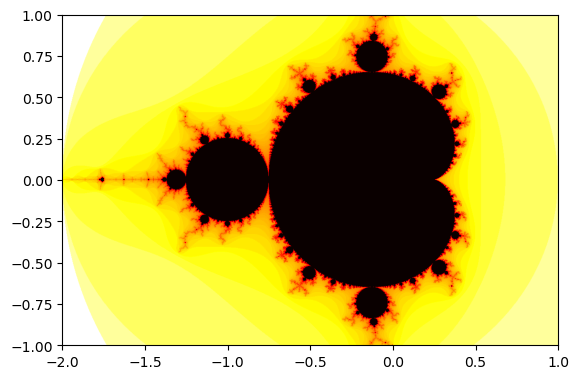

In [17]:
import matplotlib.cm as cm

imshow(-log(data3), extent=ext, cmap=cm.hot)  

## Popularity of programing languages

https://www.tiobe.com/tiobe-index/
